# Download the COE dataset

Dataset copied from [data.gov.sg](https://data.gov.sg/datasets/d_69b3380ad7e51aff3a7dcc84eba52b8a/view)

In [1]:
!curl -sLO https://github.com/joetanx/study/raw/refs/heads/main/coe-example/COEBiddingResultsPrices.csv

# Review the dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
df = pd.read_csv('COEBiddingResultsPrices.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   month          1860 non-null   object
 1   bidding_no     1860 non-null   int64 
 2   vehicle_class  1860 non-null   object
 3   quota          1860 non-null   int64 
 4   bids_success   1860 non-null   object
 5   bids_received  1860 non-null   object
 6   premium        1860 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 101.8+ KB


# Processing the date
- COE biddings happen twice a month (typically first and third Wednesdays).
- Hence, the COE dataset contains `month` and `bidding_no` columns
- To facilitate data visualization, let's assign first bidding to 1st and second bidding to 15th of the month
- Let's add a new `date` column, and drop the original `month` and `bidding_no` columns

In [3]:
df['date'] = df.apply(lambda row: f"{row['month']}-{('01' if row['bidding_no'] == 1 else '15')}", axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns=['month', 'bidding_no'])
df = df[['date'] + [col for col in df.columns if col != 'date']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1860 non-null   datetime64[ns]
 1   vehicle_class  1860 non-null   object        
 2   quota          1860 non-null   int64         
 3   bids_success   1860 non-null   object        
 4   bids_received  1860 non-null   object        
 5   premium        1860 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 87.3+ KB


# Processing bids to numeric
- Notice that `bids_received` and `bids_success` are `object` instead of `int64`
- This is because the column values contains commas `,`, so let's scrub them away

In [4]:
df['bids_received'] = df['bids_received'].str.replace(',', '', regex=False)
df['bids_received'] = pd.to_numeric(df['bids_received'])
df['bids_success'] = df['bids_success'].str.replace(',', '', regex=False)
df['bids_success'] = pd.to_numeric(df['bids_success'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1860 non-null   datetime64[ns]
 1   vehicle_class  1860 non-null   object        
 2   quota          1860 non-null   int64         
 3   bids_success   1860 non-null   int64         
 4   bids_received  1860 non-null   int64         
 5   premium        1860 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 87.3+ KB


# Trying to plot `quota` and `bids_received`

Let's limit the `vehicle_class` to `Category B` and range in 2023 for simple visualization

In [5]:
df_b = df[df['vehicle_class'] == 'Category B']
df_b = df_b[(df_b['date'] >= '2023-01-01') & (df_b['date'] <= '2023-12-31')]

Plotting a stacked bar chart on `quota` and `bids_received` against time

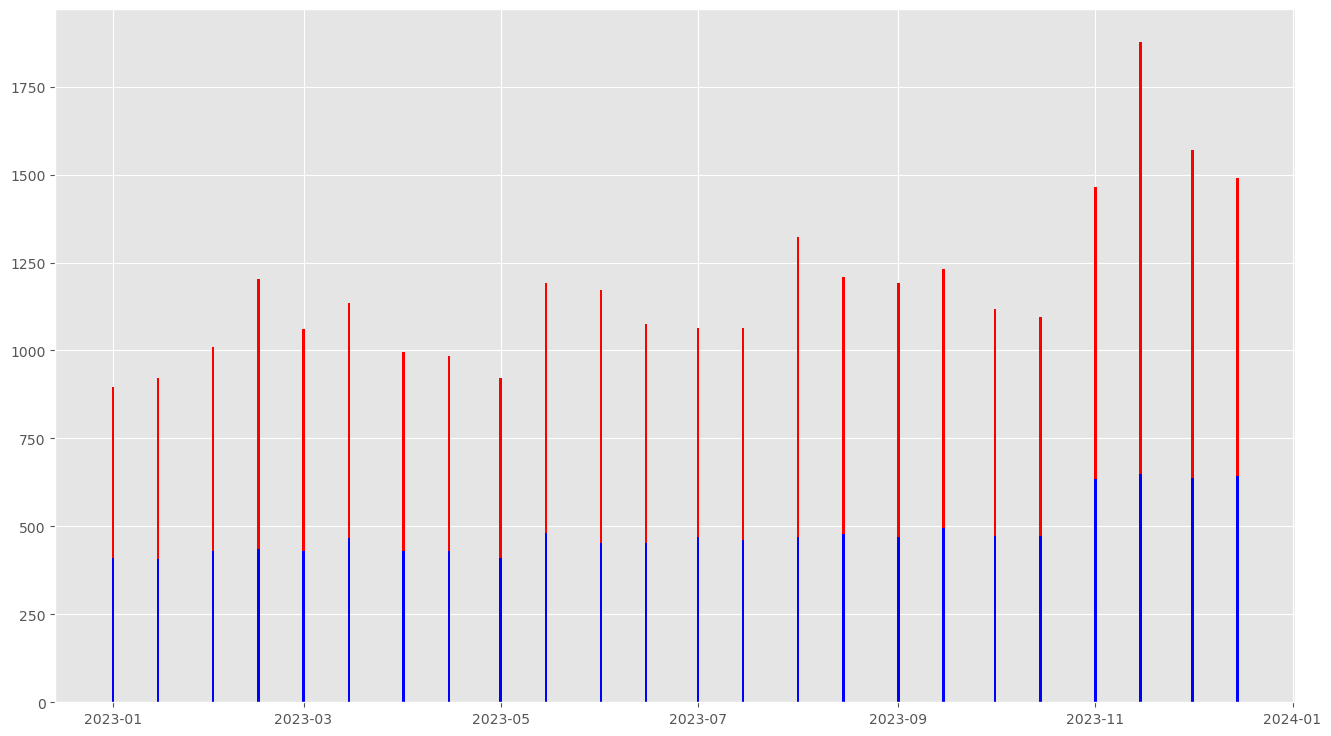

In [6]:
plt.figure(figsize=(16, 9))
plt.bar(df_b['date'], df_b['quota'], label='Quota', color='b')
plt.bar(df_b['date'], df_b['bids_received'], bottom=df_b['quota'], label='Bids Received', color='r')
plt.show()

# Visualizing the COE premium movement

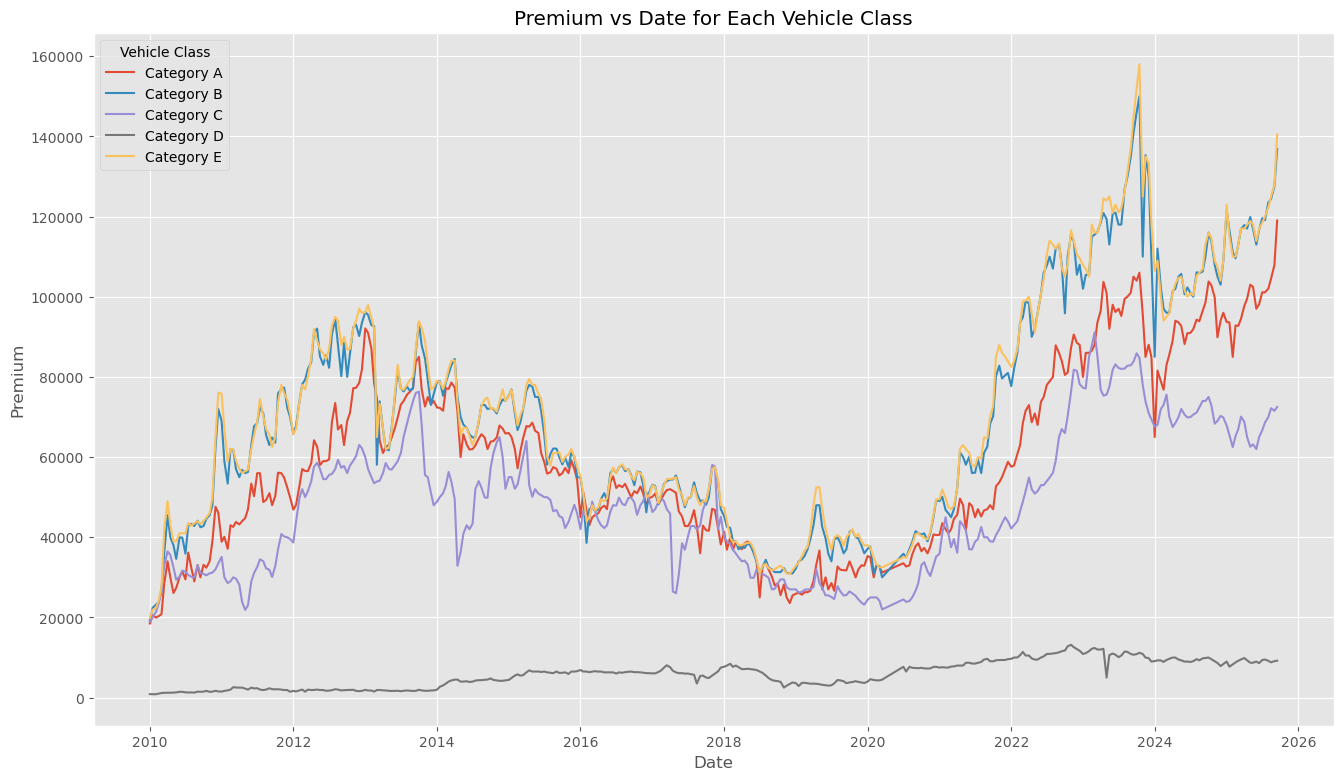

In [7]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=df, x='date', y='premium', hue='vehicle_class')
plt.title('Premium vs Date for Each Vehicle Class')
plt.xlabel('Date')
plt.ylabel('Premium')
plt.legend(title='Vehicle Class')

# Reviewing the correlation between quota and premium
We know that premium increases as quota decrease, let's see this visually

<Axes: >

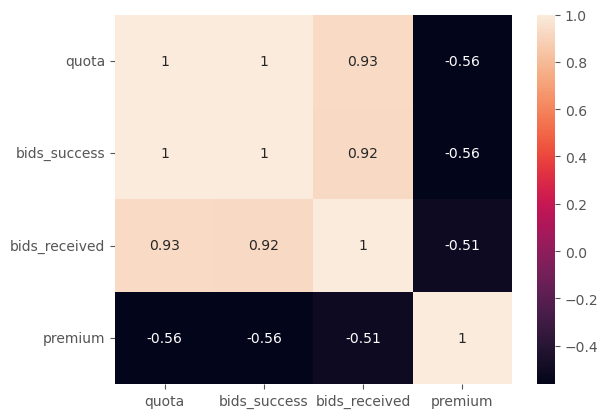

In [8]:
df_b = df[df['vehicle_class'] == 'Category B']
df_b_corr = df_b[['quota','bids_success','bids_received','premium']].dropna().corr()
sns.heatmap(df_b_corr, annot=True)

Another characteristics of COE premium movement is that the premium reaction lags slightly in response to quota changes

Let's shift the quota slightly and see the correlation again

<Axes: >

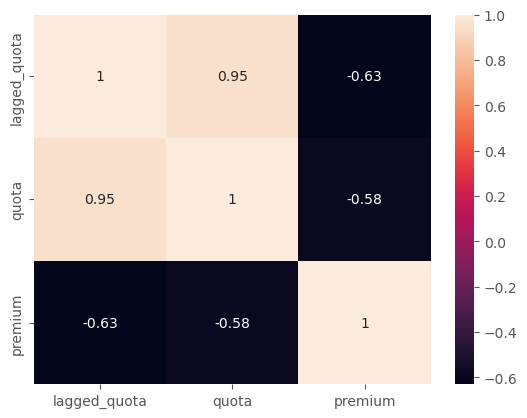

In [9]:
df_b = df[df['vehicle_class'] == 'Category B'].copy()
df_b['lagged_quota'] = df_b['quota'].shift(8)
df_b.dropna(inplace=True)
df_b_corr = df_b[['lagged_quota','quota','premium']].dropna().corr()
df_b_corr
sns.heatmap(df_b_corr, annot=True)

# Visualize the distribution for premium against quota

<Axes: title={'center': 'Cat B: Premium vs. Quota'}, xlabel='Quota', ylabel='Premium'>

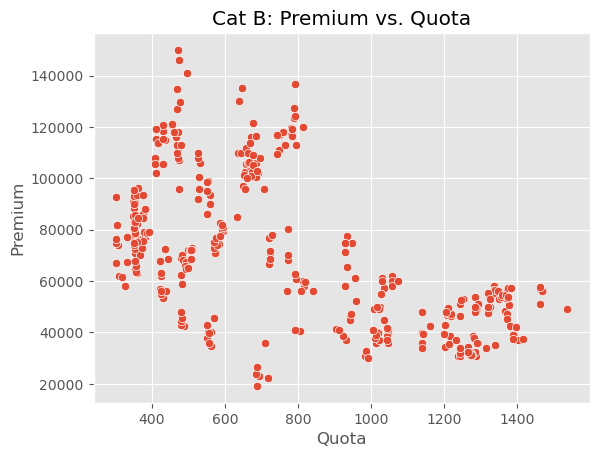

In [10]:
df_b = df[df['vehicle_class'] == 'Category B']
plt.title(label='Cat B: Premium vs. Quota')
plt.xlabel(xlabel='Quota')
plt.ylabel(ylabel='Premium')
sns.scatterplot(x='quota', y='premium', data=df_b)

Looking at the distribution in a density view

<Axes: title={'center': 'Cat B: Premium vs. Quota'}, xlabel='Quota', ylabel='Premium'>

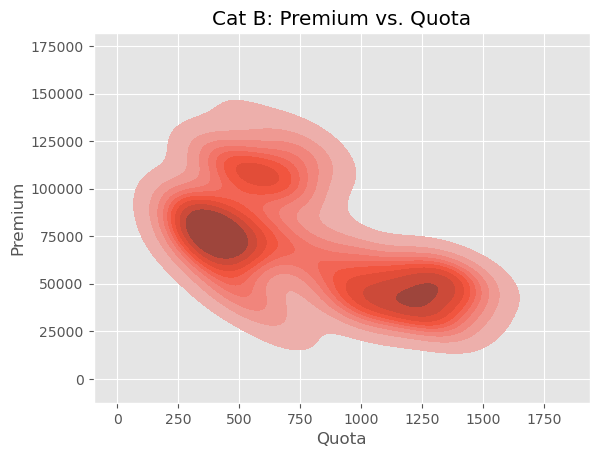

In [11]:
df_b = df[df['vehicle_class'] == 'Category B']
plt.title(label='Cat B: Premium vs. Quota')
plt.xlabel(xlabel='Quota')
plt.ylabel(ylabel='Premium')
sns.kdeplot(x='quota', y='premium', data=df_b, fill=True)

While the scatter and density plot shows that generally high premium is associated with low quota and vice versa, there seems to be some data points that suggests low premium can also occur for low quota

Let's adjust the visualization window slightly to the last 10 years and see

<Axes: title={'center': 'Cat B: Premium vs. Quota'}, xlabel='Quota', ylabel='Premium'>

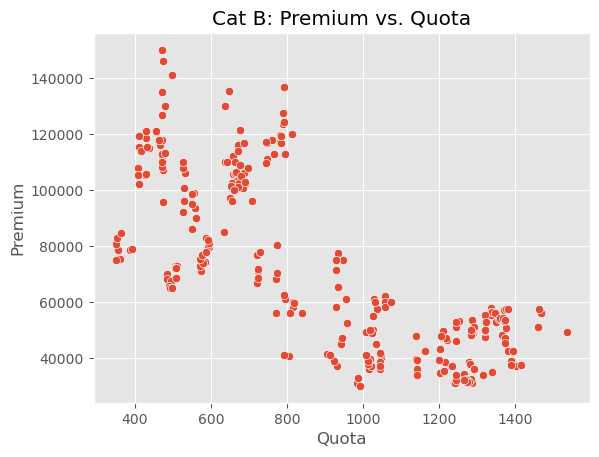

In [12]:
df_b = df[df['vehicle_class'] == 'Category B']
df_b = df_b[(df_b['date'] >= '2014-01-01')]
plt.title(label='Cat B: Premium vs. Quota')
plt.xlabel(xlabel='Quota')
plt.ylabel(ylabel='Premium')
sns.scatterplot(x='quota', y='premium', data=df_b)

The inverse relationship between premium and quota appears to be more distinct for the later years

<Axes: title={'center': 'Cat B: Premium vs. Quota'}, xlabel='Quota', ylabel='Premium'>

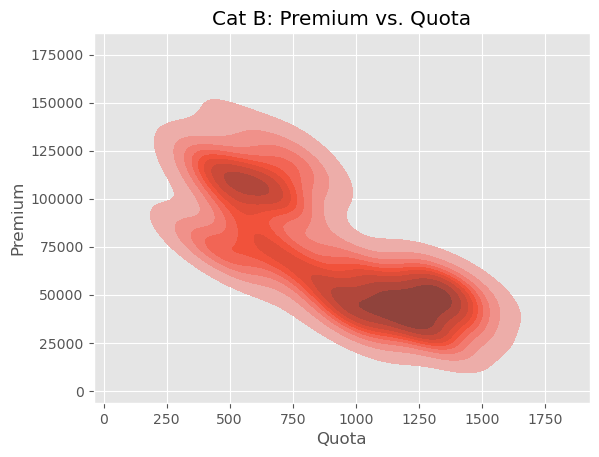

In [13]:
df_b = df[df['vehicle_class'] == 'Category B']
df_b = df_b[(df_b['date'] >= '2014-01-01')]
plt.title(label='Cat B: Premium vs. Quota')
plt.xlabel(xlabel='Quota')
plt.ylabel(ylabel='Premium')
sns.kdeplot(x='quota', y='premium', data=df_b, fill=True)

# Visualizing data in sub-plots

Visualizing all COE categories in 1 plot would make the plot overly cluttered and hard to discern any pattern

Multiple similar sub-plots can be generated using a `for` loop

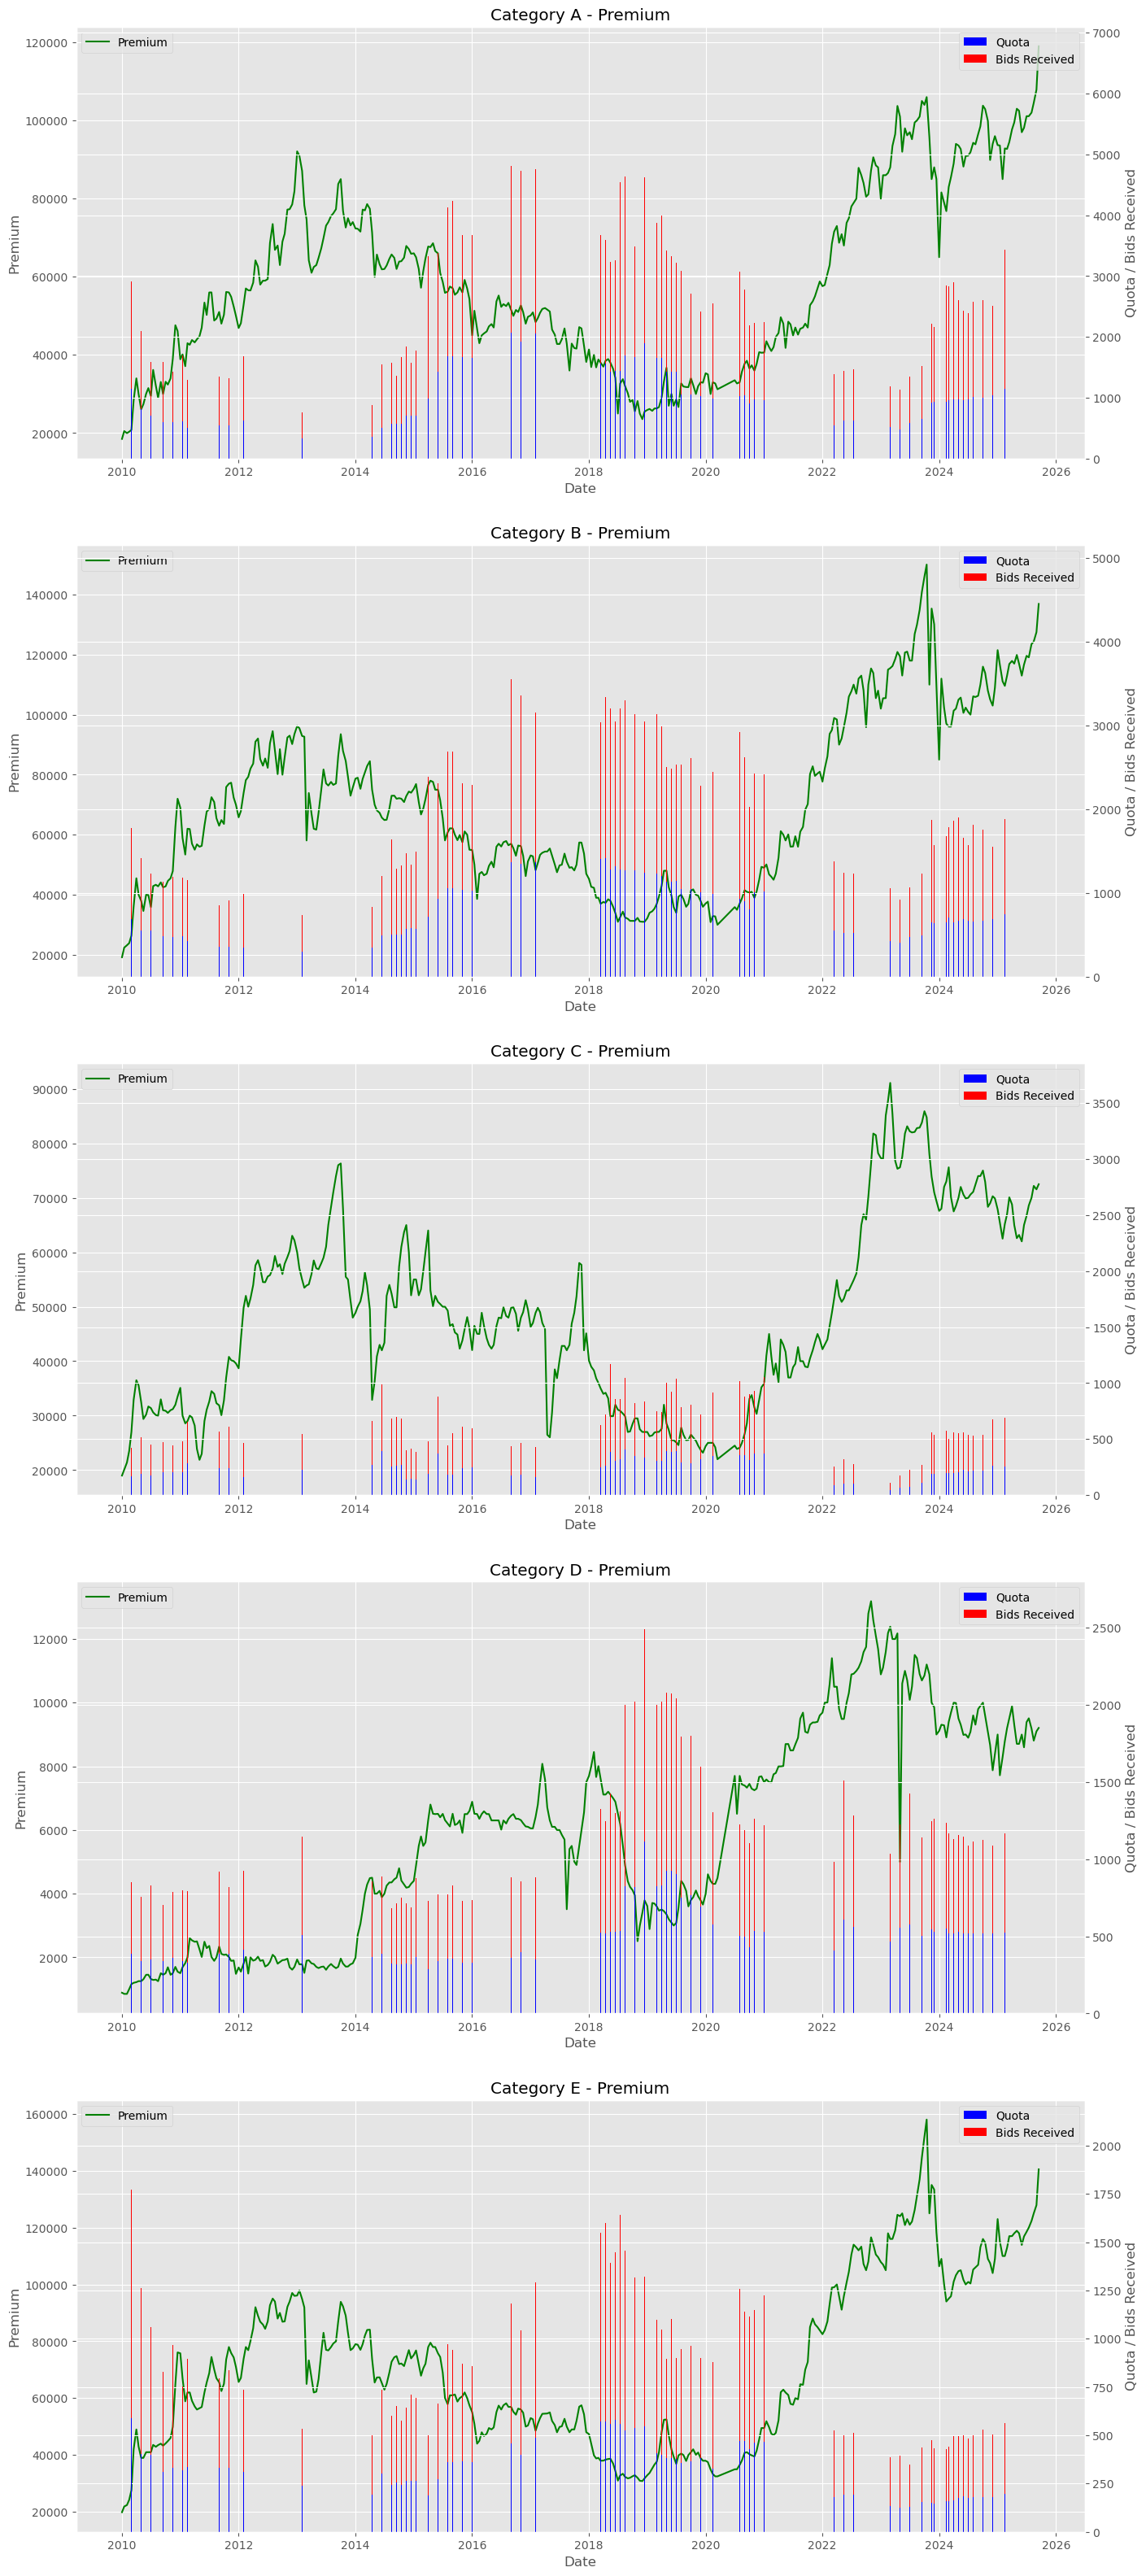

In [14]:
fig, axs = plt.subplots(5, 1, figsize=(16, 40))
axs = axs.flatten()
vehicle_classes = df['vehicle_class'].unique()
for i, vehicle_class in enumerate(vehicle_classes):
    ax1 = axs[i]

    # Filter data for the specific vehicle class
    class_data = df[df['vehicle_class'] == vehicle_class]
    
    # Plotting the premium as a line plot
    sns.lineplot(data=class_data, x='date', y='premium', ax=ax1, label='Premium', color='g')
    
    # Stacked bar plot for quota and bids_received
    ax2 = ax1.twinx()
    ax2.bar(class_data['date'], class_data['quota'], color='b', label='Quota')
    ax2.bar(class_data['date'], class_data['bids_received'], bottom=class_data['quota'], color='r', label='Bids Received')

    # Set the titles and labels
    ax1.set_title(f'{vehicle_class} - Premium')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Premium')
    ax2.set_ylabel('Quota / Bids Received')

    # Legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Visualizing premium fluctuations over the years

More insights on the premium volatility can be identified with a [box and whisker](https://datavizcatalogue.com/methods/box_plot.html) plot

Text(0, 0.5, 'Premium')

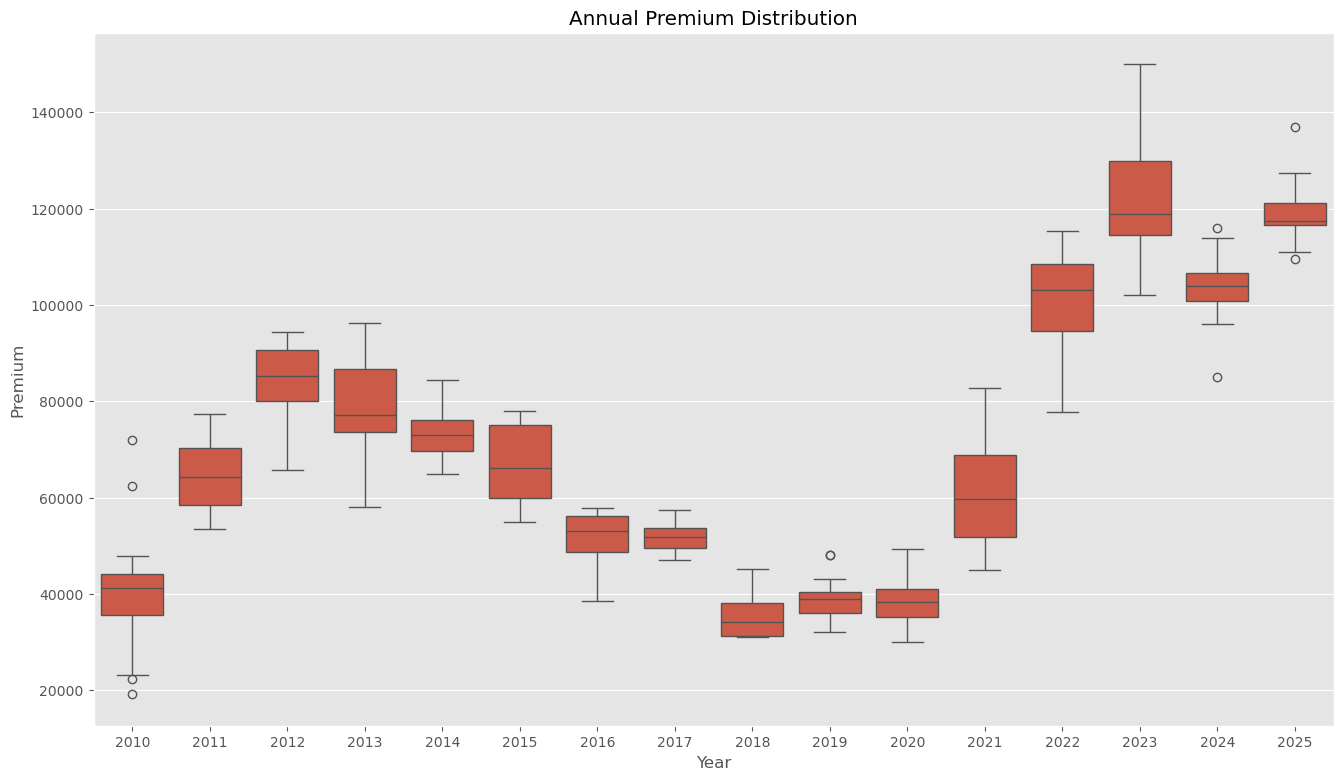

In [15]:
df['year'] = df['date'].dt.year
df_b = df[df['vehicle_class'] == 'Category B']
yearly_stats = df_b.groupby('year')['premium'].describe(percentiles=[0.25, 0.5, 0.75])
yearly_stats
plt.figure(figsize=(16, 9))
sns.boxplot(x='year', y='premium', data=df_b)
plt.title('Annual Premium Distribution')
plt.xlabel('Year')
plt.ylabel('Premium')

It seems that there are cases where the premiums get so violatile that there are outliers beyond the min and max whiskers, let's look at the outliers for 2010

In [16]:
df_b_year_slice = df_b[df_b['year'] == 2010]
df_b_year_slice['premium'].min()

19190

In [17]:
df_b_year_slice['premium'].max()

72001

# Learning points
- The outliers in 2010 may have been the cause of the premuim vs quota scatter/density plot showing execption cases
- Through the box and whisker visualization, COE premiums can move quite drastically (more violatile) with either longer whiskers or even outliers
- Looking at 2024, there seeems to be some outlier values despite it seemingly being a less violatile year (small box and short whiskers)